# 目的
大山に設置してある環境センサーのデータから、リアルタイムに20分後の天気を予測する
# 内容
センサーデータの取得 <br>
データの前処理 <br>
基本統計量の確認 <br>
データをプロットしてみて、データ特性を掴む

In [71]:
import numpy
import csv
from sensor import *
import copy
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import time
import datetime
import math
from pylab import *
# グラフをインラインで表示させる
%matplotlib inline

# データの取得
「sensor.py」の中のOhyamaクラスを呼び出し、データを取得する

In [2]:
ohyama = Ohyama()

In [3]:
F_MOUNTH = '07'
F_DAY = '01'
T_MOUNTH = '09'
T_DAY = '01'
f = '2016-' + F_MOUNTH + '-' + F_DAY + 'T00:00:00%2B00:00'
t = '2016-' +  T_MOUNTH + '-' + T_DAY + 'T00:00:00%2B00:00'

In [4]:
data = ohyama.sensor_list[0].get_data(From=f, To=False, interval='60000')

In [5]:
df = pd.DataFrame(data[1], columns=data[0])
df = df.drop(df[df['numerics.wind.direction'] == ''].index)
df.head()

time numerics.temperature.atmospheric  \
0  1.468645e+12                             20.1   
1  1.468646e+12                             19.9   
2  1.468646e+12                             19.9   
3  1.468647e+12                             19.9   
4  1.468647e+12                             19.7   

  numerics.humidity.atmospheric numerics.illumination.atmospheric  \
0                            98                            7896.8   
1                            99                            7613.3   
2                            98                            7405.4   
3                            98                            8797.7   
4                            98                            7972.4   

  numerics.rain.precipitation numerics.wind.direction numerics.wind.velocity  \
0                           0                     197                      0   
1                           0                     153                      0   
2                           0                     178                      0   
3                           0                     179                    0.1   
4                           0                     184                      0   

  numerics.wind.maxInstantaneousVelocity  numerics.pressure.atmospheric  
0                                      0                          932.0  
1                                      0                          932.0  
2                                    1.1                          932.0  
3                                    2.2                          932.0  
4                                    1.1                          932.0

## データを数値型に変換する関数を定義

In [6]:
def df2float(df):
    d = df.as_matrix().astype(np.float64)
    datetime_list = []
    for t in d.T[0]:
        datetime_list.append(pd.to_datetime(datetime.datetime(*time.localtime(float(t)/1000)[:6])))
    break_list = [1]
    diff_cos = [0.0]
    diff_cos = [0.0]
    for i in range(1,len(d.T[0])):
        if d.T[0][i] - d.T[0][i-1]  > 1000000.0:
            break_list.append(1)
        else:
            break_list.append(0)
    
    df_tmp = pd.DataFrame(d, columns=df.columns)
    df_tmp['detetime'] = datetime_list
    df_tmp['break'] = break_list
    
    return df_tmp

## データの向きをsinとcosに分解する
そのままのデータだと、風の向きは0〜360の数値になっている　<br>
このまま予測モデルを作ろうとすると、0と360の意味は同じなのに、数値上は全く違うものと判断してしまう<br>
そこで、風の向きをsinとcosに分解する <br>
分解すると風の向き0〜360が、sin（-1〜1）とcos(-1〜1)にすることができる

In [7]:
def v2sincos(df):
    df_tmp = df
    v_list = df[['numerics.wind.direction']].as_matrix().T[0]
    result = np.array([cos(np.deg2rad(v_list))])
    result = np.append(result, np.array([sin(np.deg2rad(v_list))]), axis=0)
    #print(result[0])
    df_tmp['wind_direction_cos'] = result[0]
    df_tmp['wind_direction_sin'] = result[1]
    return df_tmp

## 風の向きの変化量を計算する

In [8]:
def calc_diff(df):
    diff_wind_direction = [0.0]
    matrix = df[['break', 'numerics.wind.direction']].as_matrix()
    for i in range(1,len(matrix)):
        if matrix[i][0] == 1:
            diff_wind_direction.append(0.0)
        else:
            if matrix[i][1] >= matrix[i-1][1]:
                if matrix[i][1] - matrix[i-1][1] <= 180:
                    diff_wind_direction.append(matrix[i][1] - matrix[i-1][1])
                else:
                    diff_wind_direction.append( -360.0 + matrix[i][1] - matrix[i-1][1])
            else:
                if matrix[i-1][1] - matrix[i][1] <= 180:
                    diff_wind_direction.append(- matrix[i-1][1] + matrix[i][1])
                else:
                    diff_wind_direction.append(360.0 - (matrix[i-1][1] - matrix[i][1]))
                    
    df_tmp = df
    df_tmp['diff_wind_direction'] = diff_wind_direction
    return df_tmp

# 上記関数を使ってデータを加工

In [9]:
df = df2float(df)
df = v2sincos(df)
df = calc_diff(df)

In [10]:
df.head()

time  numerics.temperature.atmospheric  \
0  1.468645e+12                              20.1   
1  1.468646e+12                              19.9   
2  1.468646e+12                              19.9   
3  1.468647e+12                              19.9   
4  1.468647e+12                              19.7   

   numerics.humidity.atmospheric  numerics.illumination.atmospheric  \
0                           98.0                             7896.8   
1                           99.0                             7613.3   
2                           98.0                             7405.4   
3                           98.0                             8797.7   
4                           98.0                             7972.4   

   numerics.rain.precipitation  numerics.wind.direction  \
0                          0.0                    197.0   
1                          0.0                    153.0   
2                          0.0                    178.0   
3                          0.0                    179.0   
4                          0.0                    184.0   

   numerics.wind.velocity  numerics.wind.maxInstantaneousVelocity  \
0                     0.0                                     0.0   
1                     0.0                                     0.0   
2                     0.0                                     1.1   
3                     0.1                                     2.2   
4                     0.0                                     1.1   

   numerics.pressure.atmospheric            detetime  break  \
0                          932.0 2016-07-16 13:54:19      1   
1                          932.0 2016-07-16 14:05:01      0   
2                          932.0 2016-07-16 14:15:12      0   
3                          932.0 2016-07-16 14:25:12      0   
4                          932.0 2016-07-16 14:35:12      0   

   wind_direction_cos  wind_direction_sin  diff_wind_direction  
0           -0.956305           -0.292372                  0.0  
1           -0.891007            0.453990                -44.0  
2           -0.999391            0.034899                 25.0  
3           -0.999848            0.017452                  1.0  
4           -0.997564           -0.069756                  5.0

## 基本統計量の確認

In [67]:
df.describe()

time  numerics.temperature.atmospheric  \
count  1.871800e+04                      18718.000000   
mean   1.476079e+12                         15.911818   
std    4.575160e+09                          7.412146   
min    1.468645e+12                        -14.400000   
25%    1.472022e+12                          9.800000   
50%    1.475874e+12                         17.800000   
75%    1.480121e+12                         21.900000   
max    1.484203e+12                         34.600000   

       numerics.humidity.atmospheric  numerics.illumination.atmospheric  \
count                   18718.000000                       18718.000000   
mean                       75.657335                       12091.767213   
std                        19.305163                       20897.366160   
min                        18.000000                           0.000000   
25%                        62.000000                           0.000000   
50%                        80.000000                        1261.500000   
75%                        92.000000                       14014.150000   
max                        99.000000                      116657.200000   

       numerics.rain.precipitation  numerics.wind.direction  \
count                 18718.000000             18718.000000   
mean                      0.059894               167.569719   
std                       0.429887                84.663145   
min                       0.000000                 0.000000   
25%                       0.000000               128.000000   
50%                       0.000000               176.000000   
75%                       0.000000               203.000000   
max                      18.600000               359.000000   

       numerics.wind.velocity  numerics.wind.maxInstantaneousVelocity  \
count            18718.000000                            18718.000000   
mean                 0.196479                                1.614713   
std                  0.297024                                1.442303   
min                  0.000000                                0.000000   
25%                  0.000000                                1.100000   
50%                  0.100000                                1.100000   
75%                  0.300000                                2.200000   
max                  4.100000                               22.300000   

       numerics.pressure.atmospheric         break  wind_direction_cos  \
count                   18718.000000  18718.000000        18718.000000   
mean                      936.663746      0.006251           -0.361591   
std                         6.084653      0.078816            0.764696   
min                       910.000000      0.000000           -1.000000   
25%                       933.000000      0.000000           -0.981627   
50%                       937.000000      0.000000           -0.829038   
75%                       941.000000      0.000000            0.374607   
max                       951.000000      1.000000            1.000000   

       wind_direction_sin  diff_wind_direction  
count        18718.000000         18718.000000  
mean             0.057230            -0.002458  
std              0.530342            44.720493  
min             -1.000000          -180.000000  
25%             -0.292372           -14.000000  
50%              0.052336             0.000000  
75%              0.438371            15.000000  
max              1.000000           180.000000

# 雨が降り出した時の風の変化を確認する
Graphanaにリアルタイムに表示されるセンサーデータを見て、雨が降る前には湿度の変化以外に、独特な風の変化があるのではと仮説を立てた <br>
雨が降り出した時間を取得し、その２時間前までの風の変化を確認する

In [11]:
def plot_sincos(df, datetime_s = 0, datetime_f = 0, hour_ago = 3):
    f = df['time'].as_matrix()[-1]
    #　3時間分のデータを表示
    s = f - 60000 * 60 * hour_ago
    if isinstance(datetime_f, datetime.datetime) :
        f = float(time.mktime(datetime_f.timetuple())) * 1000
    if isinstance(datetime_s, datetime.datetime) :
        s = float(time.mktime(datetime_s.timetuple())) * 1000
    else:
        s = f - 60000 * 60 * hour_ago
    df_tmp = df[df['time'] > s]
    df_tmp = df_tmp[df_tmp['time'] <= f]
    
    dd = df_tmp[['time', 'wind_direction_cos', 'wind_direction_sin', 'diff_wind_direction']].as_matrix()
    t_s = dd[0][0]
    
    print(len(dd))
    
    x = (dd.T[0] - t_s) / 60000 / 60
    t_f = dd[-1][0]
    plt.plot(x, dd.T[1], color='b', label="cos")
    plt.plot(x, dd.T[2], color='r', label='sin')
    plt.plot(x, dd.T[3]/180.0, color='g', label='diff')
    ylim(-1,1)
    plt.legend()

In [13]:
rain_datetime = []
for dt in df[df['numerics.rain.precipitation'] > 0.5][['detetime']].as_matrix().T[0]:
    rain_datetime.append(datetime.datetime.utcfromtimestamp(dt.tolist()/1e9))

In [14]:
rain_datetime_first = []
for i, r in enumerate(rain_datetime):
    s_time = r - datetime.timedelta(hours = 1)
    bl = False
    for r2 in rain_datetime[i-10:i]:
        if r2 > s_time:
            bl = True
            break
    if bl:
        rain_datetime_first.append(r)

## 雨が降り出す前の風の変化をプロットして確認

12


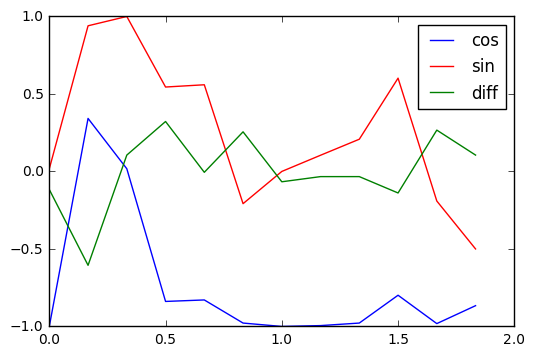

In [19]:
plot_sincos(df, 0, rain_datetime_first[11], 2)

In [15]:
len(rain_datetime)

586

In [16]:
len(rain_datetime_first)

469

# データの分布をヒストグラムで確認

In [68]:
rain_dt = []
cos_datas = []
sin_datas = []
diff_datas = []
vel_datas = []
velm_datas = []
hum_datas = []
for r in rain_datetime_first:
    f = float(time.mktime(r.timetuple())) * 1000
    s = f - 60000 * 60 * 2
    
    df_tmp = df[df['time'] > s]
    df_tmp = df_tmp[df_tmp['time'] <= f]
    
    dd = df_tmp[['time', 'wind_direction_cos', 'wind_direction_sin', 'diff_wind_direction', 'numerics.wind.velocity', 'numerics.wind.maxInstantaneousVelocity', 'numerics.humidity.atmospheric']].as_matrix()
    if len(dd) == 12:
        rain_dt.append(r)
        cos_datas.append(dd.T[1])
        sin_datas.append(dd.T[2])
        diff_datas.append(dd.T[3]/180.0)
        v_tmp = []
        vm_tmp = []
        for v, vm in zip(dd.T[4], dd.T[5]):
            if v < 0.1:
                v_tmp.append(0.0)
            elif v < 0.3:
                v_tmp.append(1.0)
            else:
                v_tmp.append(2.0)
            
            if vm < 1.1:
                vm_tmp.append(0.0)
            elif vm < 2.2:
                vm_tmp.append(1.0)
            else:
                vm_tmp.append(2.0)
        
        vel_datas.append(v_tmp)
        velm_datas.append(vm_tmp)
        hum_datas.append(dd.T[6])

In [18]:
len(rain_dt)

458

In [69]:
df_r = pd.DataFrame(rain_dt, columns=['rain_time'])
df_c = pd.DataFrame(cos_datas)
df_s = pd.DataFrame(sin_datas)
df_d = pd.DataFrame(diff_datas)
df_v = pd.DataFrame(vel_datas)
df_vm = pd.DataFrame(velm_datas)
df_h = pd.DataFrame(hum_datas)

In [70]:
df_r.to_csv('rain_data/rain_dt.csv', index=None)
df_s.to_csv('rain_data/cos_datas.csv', index=None)
df_c.to_csv('rain_data/sin_datas.csv', index=None)
df_d.to_csv('rain_data/diff_datas.csv', index=None)
df_v.to_csv('rain_data/vel_datas.csv', index=None)
df_vm.to_csv('rain_data/velm_datas.csv', index=None)
df_h.to_csv('rain_data/hum_datas.csv', index=None)

## 風の強さをヒストグラムでプロット

(array([  7.89800000e+03,   3.56100000e+03,   2.19100000e+03,
          1.50700000e+03,   1.04100000e+03,   0.00000000e+00,
          6.85000000e+02,   4.62000000e+02,   3.57000000e+02,
          2.53000000e+02,   1.73000000e+02,   0.00000000e+00,
          1.27000000e+02,   9.10000000e+01,   9.50000000e+01,
          6.30000000e+01,   0.00000000e+00,   5.60000000e+01,
          4.60000000e+01,   3.70000000e+01,   8.00000000e+00,
          1.50000000e+01,   0.00000000e+00,   1.40000000e+01,
          1.30000000e+01,   4.00000000e+00,   5.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

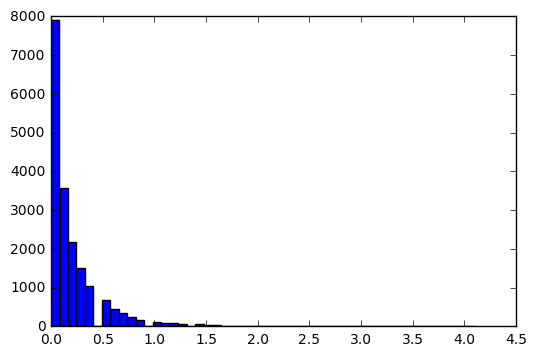

In [39]:
plt.hist(df[['numerics.wind.velocity']].as_matrix().T[0], bins=50)

## 瞬間最大風速のヒストグラムをプロット

(array([  3.82800000e+03,   7.76500000e+03,   0.00000000e+00,
          3.99500000e+03,   0.00000000e+00,   1.82100000e+03,
          0.00000000e+00,   7.72000000e+02,   0.00000000e+00,
          3.13000000e+02,   0.00000000e+00,   0.00000000e+00,
          1.23000000e+02,   4.10000000e+01,   0.00000000e+00,
          2.70000000e+01,   0.00000000e+00,   1.50000000e+01,
          0.00000000e+00,   6.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   7.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  0.    ,   0.5575,   1.115 ,   1.6725,   2.23  ,   2.7875,
          3.345 ,   3.9025,   4.46  ,   5.0175,   5.575 ,   6.1325,
          6.69  ,   7.2475,   

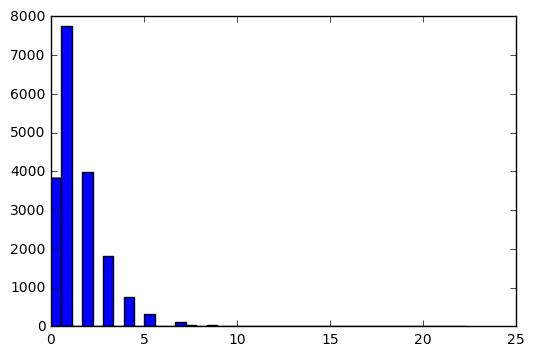

In [41]:
plt.hist(df[['numerics.wind.maxInstantaneousVelocity']].as_matrix().T[0],bins=40)

## 降雨量のヒストグラムをプロット

(array([  1.74350000e+04,   6.97000000e+02,   0.00000000e+00,
          2.24000000e+02,   1.13000000e+02,   0.00000000e+00,
          7.20000000e+01,   0.00000000e+00,   4.30000000e+01,
          2.80000000e+01,   0.00000000e+00,   2.80000000e+01,
          9.00000000e+00,   0.00000000e+00,   7.00000000e+00,
          0.00000000e+00,   7.00000000e+00,   5.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          5.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   0.00000000e+00,
        

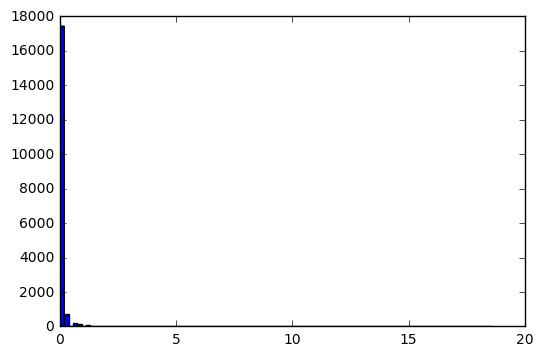

In [76]:
plt.hist(df[['numerics.rain.precipitation']].as_matrix().T[0],100)

## 照度が０より大きい時の照度のヒストグラムをプロット

(array([ 2754.,  2002.,  1334.,   865.,   514.,   322.,   268.,   221.,
          232.,   286.,   416.,   255.,   143.,   131.,    97.,    90.,
           91.,    31.,    17.,     7.]),
 array([  7.80000000e+00,   5.84027000e+03,   1.16727400e+04,
          1.75052100e+04,   2.33376800e+04,   2.91701500e+04,
          3.50026200e+04,   4.08350900e+04,   4.66675600e+04,
          5.25000300e+04,   5.83325000e+04,   6.41649700e+04,
          6.99974400e+04,   7.58299100e+04,   8.16623800e+04,
          8.74948500e+04,   9.33273200e+04,   9.91597900e+04,
          1.04992260e+05,   1.10824730e+05,   1.16657200e+05]),
 <a list of 20 Patch objects>)

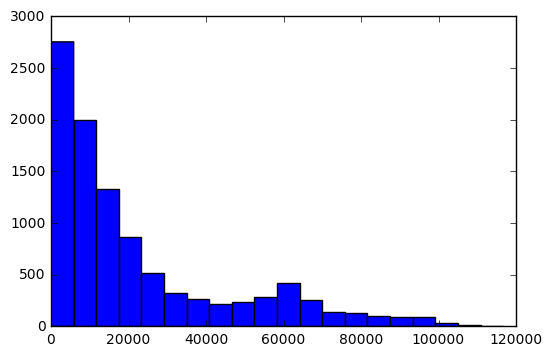

In [66]:
plt.hist(df[df['numerics.illumination.atmospheric']>0][['numerics.illumination.atmospheric']].as_matrix().T[0], bins=20)